## Prepare data

#### Text

In [1]:
from datasets import load_dataset
from shuffle_iter import *

datasets = [
    load_dataset(k, split="train", streaming=True)
    for k in (
        "ChristophSchuhmann/wikipedia-en-nov22-1-sentence-level",
        "ChristophSchuhmann/1-sentence-level-gutenberg-en_arxiv_pubmed_soda",
    )
]
shuffled_dataset_iters = [DatasetShuffleIterator(k) for k in datasets]

#### Fonts

In [2]:
from font_download import Fonts

fonts = Fonts()
fonts.download_fonts("1-K8EE0QsXfxaAV-5uOE6lhTLGicRZbW2")
random_font_iter = ShuffleIterator(fonts.font_list)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-K8EE0QsXfxaAV-5uOE6lhTLGicRZbW2
From (redirected): https://drive.google.com/uc?id=1-K8EE0QsXfxaAV-5uOE6lhTLGicRZbW2&confirm=t&uuid=4984f0ed-38ca-4080-8297-dc43bb693c85
To: C:\Users\GbotHQ\AppData\Local\Temp\tmpk46m5fbi\1-K8EE0QsXfxaAV-5uOE6lhTLGicRZbW2.zip
100%|██████████| 395M/395M [01:59<00:00, 3.31MB/s] 


#### Hdris

In [3]:
from pathlib import Path as pth
import zipfile

import gdown

zip_path = pth("../assets/")


hdris_file_id = "1BNCTqw5fenCK-D48-a7VQ234Aq3k45hu"
hdris_zip_path = zip_path / "hdris.zip"

if not hdris_zip_path.is_file():
    gdown.download(id=hdris_file_id, output=str(hdris_zip_path), quiet=False)

with zipfile.ZipFile(hdris_zip_path, "r") as zip_ref:
    zip_ref.extractall(hdris_zip_path.with_suffix(""))

In [4]:
hdris_dir = pth("../assets/hdris")

hdris = list(hdris_dir.glob("*.exr"))
random_hdri_iter = ShuffleIterator(hdris)

#### Materials

In [5]:
materials_file_id = "1-5dz5DMce-braCrhVIsqB58PvcyB6qyy"
materials_zip_path = zip_path / "materials.zip"

if not materials_zip_path.is_file():
    gdown.download(id=materials_file_id, output=str(materials_zip_path), quiet=False)

with zipfile.ZipFile(materials_zip_path, "r") as zip_ref:
    zip_ref.extractall(materials_zip_path.with_suffix(""))

In [6]:
material_dir = pth("../assets/materials")

texture_types = ["albedo", "roughness", "displacement"]

materials = {}
for file in material_dir.glob("*.jpg"):
    for k in texture_types:
        if k not in file.name:
            continue
        name = file.name.split(k, 1)[0]
        material = materials.get(name, dict.fromkeys(texture_types))
        material[k] = file
        materials[name] = material

# remove materials with missing textures
materials = {k: v for k, v in materials.items() if None not in v.values()}

random_material_iter = ShuffleIterator(list(materials.values()))

## Render text and randomize Blender scene

In [7]:
root_dir = pth.cwd() / "Blender_3D_document_rendering_pipeline"

blender_path = "C:/Program Files/Blender Foundation/Blender 3.4/blender" # path to the blender binary
blend_file_path = root_dir / "blender" / "scene_no_dof_composited_albedo.blend"
script_path = root_dir / "src" / "main.py"
output_dir_path = root_dir / "renders"
config_dir_path = root_dir / "config"

In [8]:
from typing import Tuple
from shutil import rmtree

import numpy as np
import cv2 as cv
from PIL import Image

from Blender_3D_document_rendering_pipeline.src import config


def imshow(img):
    if isinstance(img, np.ndarray):
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = Image.fromarray(img)
    display(img)


def mkdir(path: pth):
    if path.is_dir():
        rmtree(path)
    path.mkdir(parents=True)


class SampleInfo:
    def __init__(
        self,
        text: str,
        config: config.Config,
        image_path: pth,
        mask_image_path: pth,
        font_path: str,
        font_color: Tuple[int, int, int],
        font_size: int,
        text_rotation_angle: int,
        text_image_resolution: Tuple[int, int],
        output_image_resolution: Tuple[int, int],
        output_image_path: pth,
        output_coordinates_path: pth
    ):
        self.text = text
        self.config = config
        self.image_path = image_path
        self.mask_image_path = mask_image_path
        self.font_path = font_path
        self.font_color = font_color
        self.font_size = font_size
        self.text_rotation_angle = text_rotation_angle
        self.text_image_resolution = text_image_resolution
        self.output_image_resolution = output_image_resolution
        self.output_image_path = output_image_path
        self.output_coordinates_path = output_coordinates_path

In [14]:
import itertools
import re
import threading
import concurrent.futures
import multiprocessing
from io import BytesIO
from random import randint, random
import tempfile

from tqdm import tqdm
from fontTools.ttLib import TTFont
from PIL import ImageFont

from font_rendering import generate, is_text_supported_by_font


image_dir_path = pth(tempfile.mkdtemp())
print(image_dir_path)

mkdir(config_dir_path)
mkdir(image_dir_path)


text_lock = threading.Lock()
font_lock = threading.Lock()
hdri_lock = threading.Lock()


def break_up_longer_samples(_):
    # break up sentences
    with text_lock:
        text_sample = next(shuffled_dataset_iters[randint(0, 1)])["sentences"]

    # make sure that punctuation has the correct spacing
    text_sample = re.sub(r"\s*([.,])\s*", r"\1 ", text_sample)

    text_sample = [k.strip() for k in text_sample.split(", ")]
    text_sample = [k for k in text_sample if k]

    # randomly merge back some adjecent strings
    i = 0
    while (i + 1) < len(text_sample):
        if random() < 0.15:
            text_sample[i] += f", {text_sample.pop(i + 1)}"
        i += 1

    return text_sample


n_samples = 8

# get the number of CPU cores available
cpu_count = multiprocessing.cpu_count()
# cpu_count = 1

with concurrent.futures.ThreadPoolExecutor(max_workers=cpu_count) as executor:
    text_samples = executor.map(break_up_longer_samples, range(n_samples))
    # flatten
    text_samples = itertools.chain.from_iterable(text_samples)


def generate_sample(index: int):
    while True:
        # find a font that supports all characters in text
        with text_lock:
            text = next(text_samples)
        for _ in range(20):
            with font_lock:
                font_path = next(random_font_iter)
            font_file = fonts.get_font_by_path(font_path).read()
            # few fonts are be broken and will raise an exception
            try:
                if is_text_supported_by_font(text, TTFont(BytesIO(font_file))):
                    break
            except Exception as e:
                print(e)
                continue
        else:
            # give up and try a different piece of text
            print("No font found that supports all characters in text")
            continue
        break

    # few fonts are be broken and will raise an exception
    try:
        font = ImageFont.truetype(BytesIO(font_file), 42)
        text, img, mask, font_size, font_color, text_rotation_angle = generate(
            text, font
        )
    except Exception as e:
        print(f"Error while generating sample {index}: {e}")
        return

    image_path = image_dir_path / f"sample_{index:08d}.png"
    cv.imwrite(str(image_path), img, [cv.IMWRITE_PNG_COMPRESSION, 9])

    mask_image_path = image_dir_path / f"sample_{index:08d}_mask.png"
    cv.imwrite(str(mask_image_path), mask, [cv.IMWRITE_PNG_COMPRESSION, 9])

    output_image_resolution = (512, 512)
    resolution = np.array(img.shape[:2], np.float32)
    paper_size = resolution[::-1] / np.mean(resolution) * 25

    conf = config.Config(project_root=root_dir)

    with hdri_lock:
        conf.hdri.texture_path = str(next(random_hdri_iter).resolve())

    material = next(random_material_iter)
    material = {k: str(material[k].resolve()) for k in material}
    conf.ground.albedo_tex = material["albedo"]
    conf.ground.roughness_tex = material["roughness"]
    conf.ground.displacement_tex = material["displacement"]

    conf.render.resolution = output_image_resolution
    conf.render.cycles_samples = 2
    conf.paper.document_image_path = str(image_path.resolve(True))
    conf.paper.size = paper_size.tolist()
    config_path = config_dir_path / f"sample_{index:08d}.json"
    conf.ground.visible = random() < 0.6
    config.write_config(config_path, conf)

    out_dir = output_dir_path / f"sample_{index:08d}"
    out_image_path = out_dir / "image0001.png"
    out_coordinates_path = out_dir / "coordinates0001.png"

    resolution = tuple(resolution.tolist())

    return SampleInfo(
        text,
        conf,
        image_path,
        mask_image_path,
        font_path,
        font_color,
        font_size,
        text_rotation_angle,
        resolution,
        output_image_resolution,
        out_image_path,
        out_coordinates_path,
    )


with concurrent.futures.ThreadPoolExecutor(max_workers=cpu_count) as executor:
    generated_samples = list(
        tqdm(
            executor.map(generate_sample, range(n_samples)),
            total=n_samples,
            desc="Generating samples",
        )
    )

# remove failed samples
generated_samples = [k for k in generated_samples if k]

C:\Users\GbotHQ\AppData\Local\Temp\tmpr6b0uiny


Generating samples: 100%|██████████| 8/8 [00:00<00:00,  8.94it/s]


#### Show a random sample

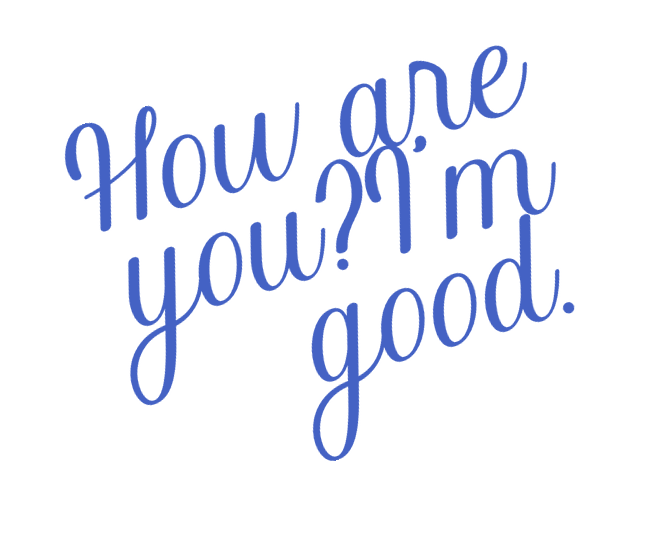

How are
you?I'm
good.


In [15]:
from random import choice

sample = choice(generated_samples)
img = cv.imread(str(sample.image_path))
imshow(img)
print(sample.text)

## Render samples using Blender

In [16]:
mkdir(output_dir_path)
device = "OPTIX" # either CPU, CUDA or OPTIX

!"$blender_path" "$blend_file_path" --background --factory-startup --threads 0 --engine CYCLES --enable-autoexec --python "$script_path" -- --cycles-device "$device"

Blender 3.4.0 (hash a95bf1ac01be built 2022-12-07 02:06:25)
Read blend: f:\GbotHQ\Documents\GitHub\ocr-dataset-rendering\src\Blender_3D_document_rendering_pipeline\blender\scene_no_dof_composited_albedo.blend
WARN (bke.anim_sys): C:\Users\blender\git\blender-v340\blender.git\source\blender\blenkernel\intern\anim_sys.c:4192 BKE_animsys_eval_driver: invalid driver - modifiers["UVWarp"].offset[0]
WARN (bke.anim_sys): C:\Users\blender\git\blender-v340\blender.git\source\blender\blenkernel\intern\anim_sys.c:4192 BKE_animsys_eval_driver: invalid driver - modifiers["GeometryNodes.003"]["Input_2"][0]
Generating 8 samples...
Failed to enable OPTIX, falling back to CUDA (when rendering from a command line, use [--engine CYCLES] with [--cycles-device OPTIX] and ignore this message)
Failed to enable CUDA, falling back to CPU (when rendering from a command line, use [--engine CYCLES] with [--cycles-device CUDA] and ignore this message)
Fra:1 Mem:115.70M (Peak 178.20M) | Time:00:01.30 | Mem:0.00M, P

#### Calculate bboxes and apply random gaussian blur

In [17]:
from scipy.ndimage import map_coordinates

from postprocess_util import imread_coords, calculate_bbox, apply_random_gauss_blur

def process_sample(k):
    # calculate bboxes
    coords, _ = imread_coords(str(k.output_coordinates_path))
    mask_image = cv.imread(str(k.mask_image_path))[..., 0]

    new_coords = coords[..., ::-1]
    new_coords = np.moveaxis(new_coords, -1, 0)
    new_coords_absolute = (
        new_coords * np.array(mask_image.shape[:2], coords.dtype)[:, None, None]
    )

    warped_image = map_coordinates(mask_image, new_coords_absolute, cval=255)
    k.bbox = calculate_bbox(warped_image, 255)
    k.bbox_relative_xxyy = k.bbox.relative(coords.shape[:2][::-1]).xxyy()

    # apply gaussian blur with random kernel size
    img = cv.imread(str(k.output_image_path))
    img, k.gaussian_blur_radius = apply_random_gauss_blur(img)
    cv.imwrite(str(k.output_image_path), img, [cv.IMWRITE_PNG_COMPRESSION, 9])


with concurrent.futures.ThreadPoolExecutor(max_workers=cpu_count) as executor:
    futures = list(executor.map(process_sample, generated_samples))

## Visualize first few generated samples

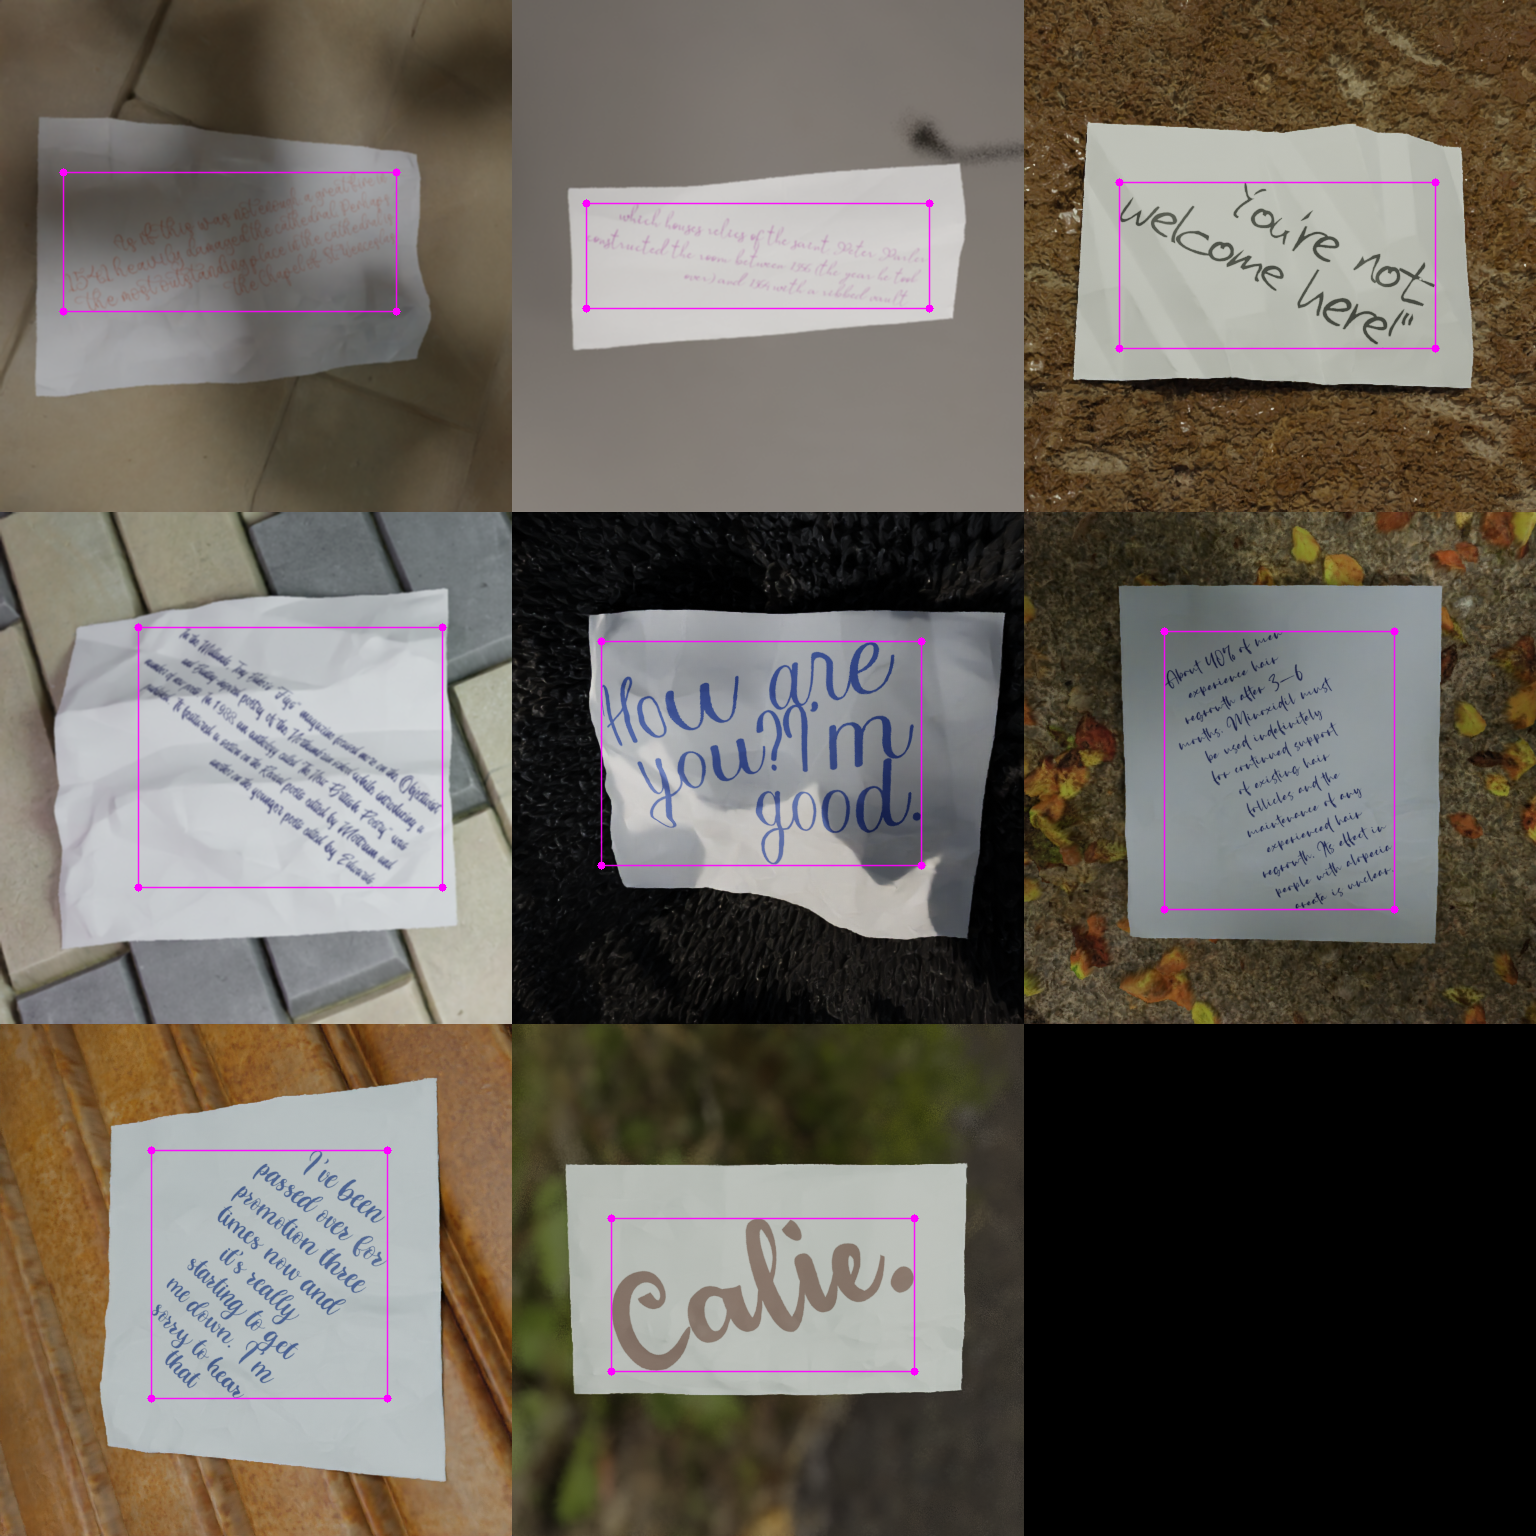

In [18]:
from postprocess_util import make_grid

count = min(len(generated_samples), 16)
output_imgs = [
    k.bbox.draw(cv.imread(str(k.output_image_path))) for k in generated_samples[:count]
]
imshow(make_grid(output_imgs))